In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing opencv-python...
Installing scikit-learn...


Copying TEST - osteoporosis: 100%|██████████| 98/98 [00:00<00:00, 114.39it/s]


Found 1552 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


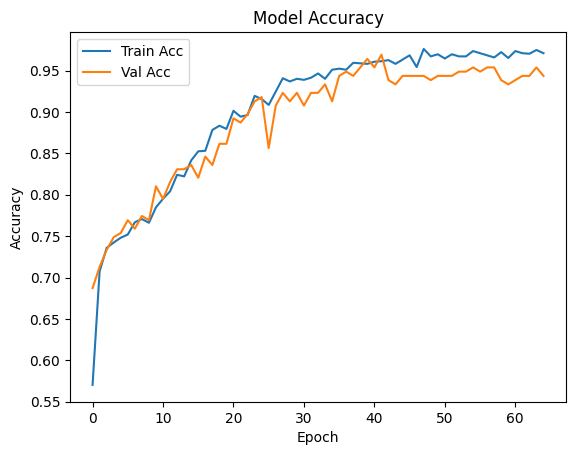

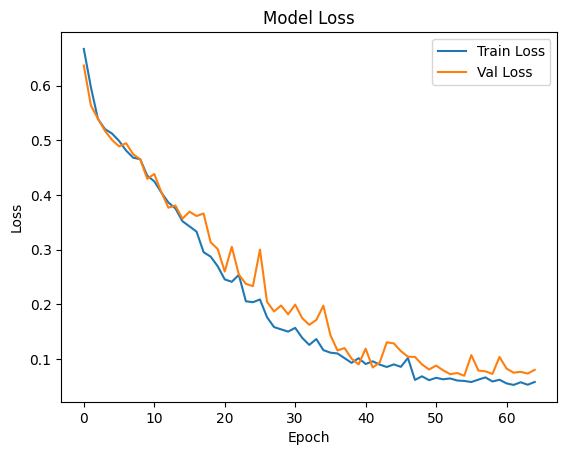

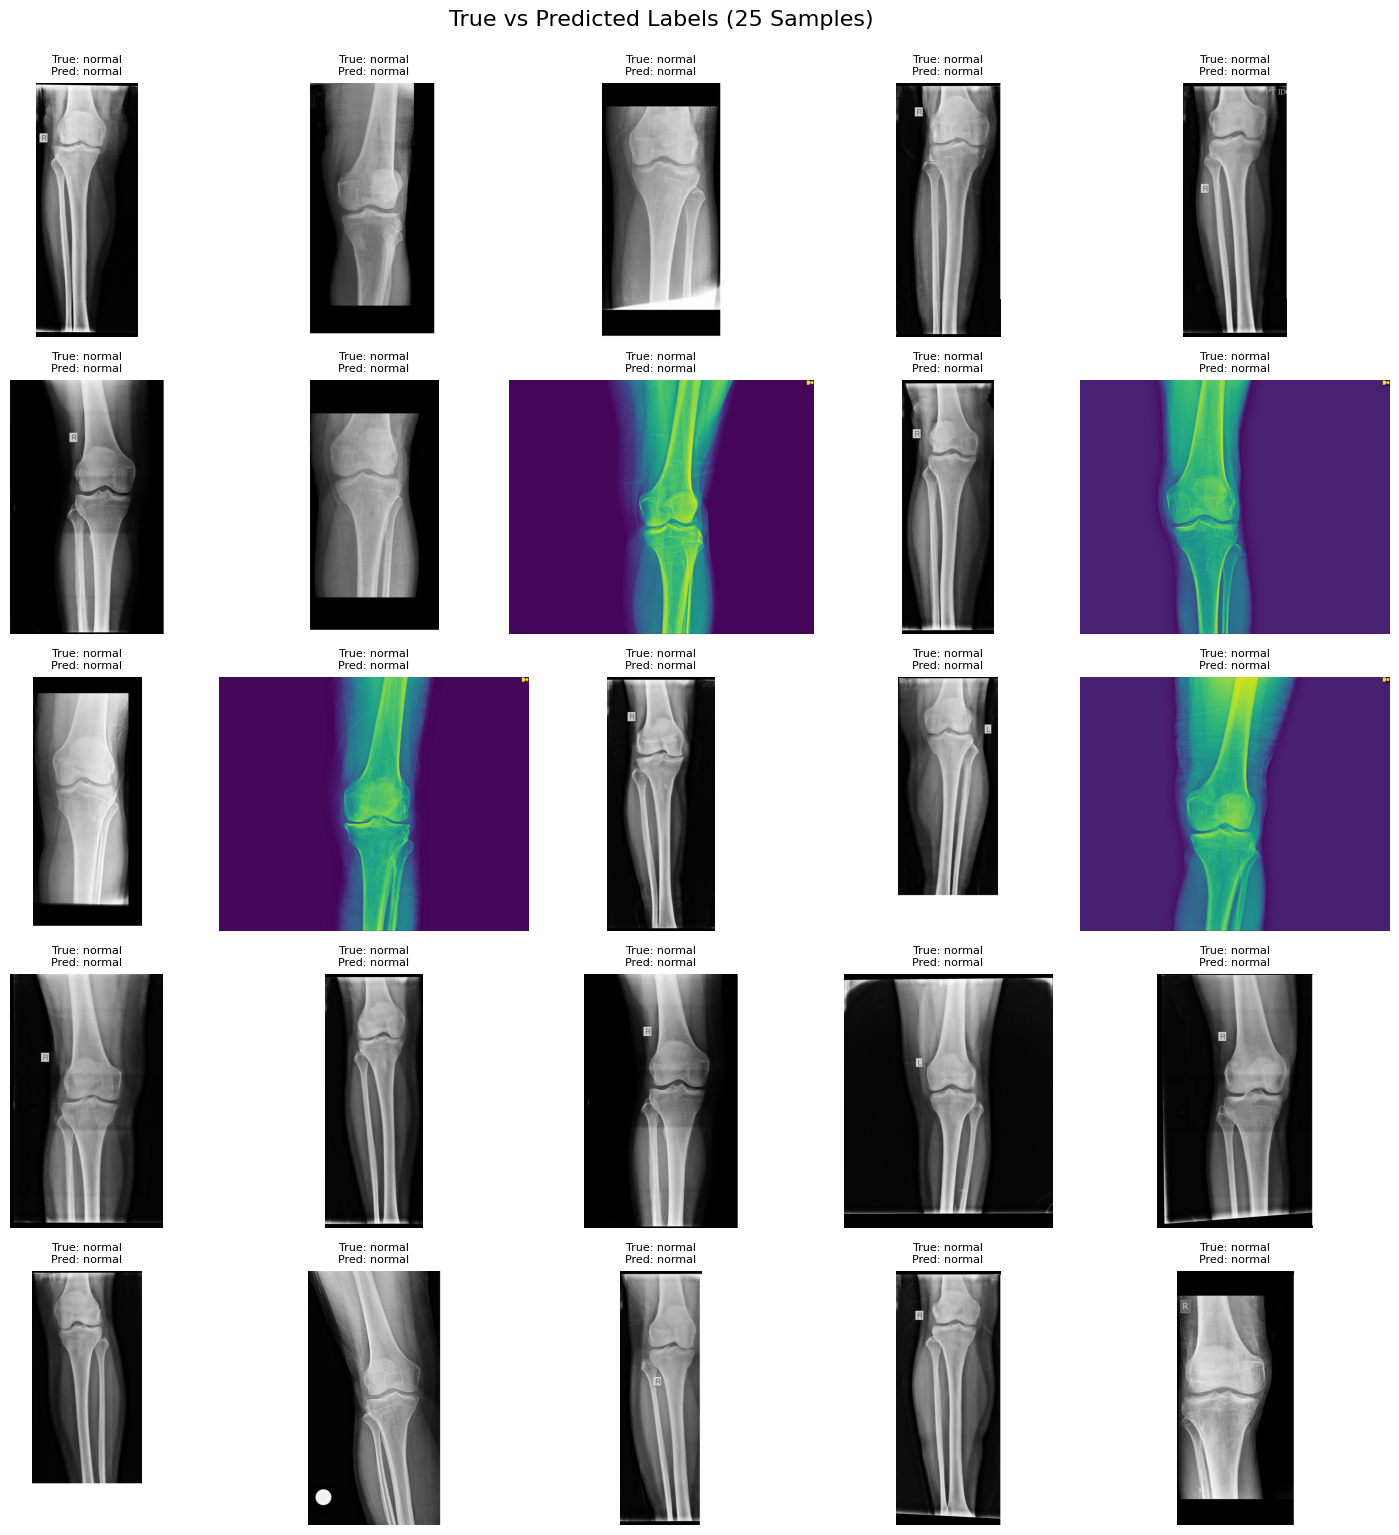

TypeError: expand_dims() missing 1 required positional argument: 'axis'

In [ ]:

import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    "tensorflow",
    "opencv-python",
    "scikit-learn",
    "matplotlib",
    "lime",
    "tqdm"
]

for package in required_packages:
    try:
        __import__(package.split('-')[0])  # handles opencv-python as opencv
    except ImportError:
        print(f"Installing {package}...")
        install(package)


import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Reshape, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# 1. Split Dataset
# ------------------------
import os
import random
import shutil
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

# Define paths
original_data_dirs = {
    'normal': '/content/drive/MyDrive/DATA/normal',
    'osteoporosis': '/content/drive/MyDrive/DATA/osteo'
}

output_base = 'dataset_split'
train_output = os.path.join(output_base, 'train')
val_output = os.path.join(output_base, 'val')
test_output = os.path.join(output_base, 'test')

# Create output dirs
for path in [train_output, val_output, test_output]:
    os.makedirs(path, exist_ok=True)

# Split ratio for train/val (rest will go to test)
split_ratio = 0.8
val_ratio = 0.1  # from full set
test_ratio = 0.1  # from full set

for class_name, class_dir in original_data_dirs.items():
    images = os.listdir(class_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * split_ratio)
    val_end = int(total * (split_ratio + val_ratio))

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    for img in tqdm(train_imgs, desc=f"Copying TRAIN - {class_name}"):
        os.makedirs(os.path.join(train_output, class_name), exist_ok=True)
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_output, class_name, img))

    for img in tqdm(val_imgs, desc=f"Copying VAL - {class_name}"):
        os.makedirs(os.path.join(val_output, class_name), exist_ok=True)
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_output, class_name, img))

    for img in tqdm(test_imgs, desc=f"Copying TEST - {class_name}"):
        os.makedirs(os.path.join(test_output, class_name), exist_ok=True)
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_output, class_name, img))

# ------------------------
# 2. Data Generators
# ------------------------

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_output, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    val_output, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    test_output, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# ------------------------
# 3. Build CNN + BiLSTM Model
# ------------------------

input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ------------------------
# 4. Callbacks and Training
# ------------------------



# Compile with a safer learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1,
    min_lr=1e-7  # Optional: prevent it from going too low
)

# Train
# history = model.fit(
#     train_gen,
#     epochs=100,
#     validation_data=val_gen,
#     callbacks=[early_stop, reduce_lr]
# )
# model.save('/content/drive/MyDrive/modelsss/btccoded.keras')


# ------------------------
# 5. Plot Training History
# ------------------------


plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ------------------------
# 6. Evaluation
# ------------------------

# ------------------------
# 7. Plot 25 Predictions
# ------------------------

file_paths = test_gen.filepaths

plt.figure(figsize=(15, 15))
for i in range(25):
    img = plt.imread(file_paths[i])
    true_label = class_labels[y_true[i]]
    pred_label = class_labels[y_pred[i]]

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("True vs Predicted Labels (25 Samples)", fontsize=16, y=1.02)
plt.show()

# ------------------------
# GRAD CAM
# ------------------------
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import matplotlib.cm as cm
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------- Grad-CAM Heatmap Function ---------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # binary: 0 or 1
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + K.epsilon())
    return heatmap.numpy()

# --------- Grad-CAM Display Function ---------
def display_gradcam(image_path, model, last_conv_layer_name='conv2', label=''):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM - {label}')
    plt.axis('off')
    plt.show()

# --------- Example Usage ---------
# Show Grad-CAM on 3 test images
for idx in range(3):
    image_path = file_paths[idx]
    true_label = class_labels[y_true[idx]]
    pred_class = int(model.predict(np.expand_dims(cv2.resize(cv2.imread(image_path), (IMG_WIDTH, IMG_HEIGHT))) / 255.0)[0][0] > 0.5)
    pred_label = class_labels[pred_class]
    label = f"True: {true_label}, Pred: {pred_label}"
    display_gradcam(image_path, model, last_conv_layer_name='conv2', label=label)



In [ ]:
print(test_gen.class_indices)  # {'normal': 0, 'osteoporosis': 1} for example
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_gen.classes
)
print("Class Weights:", dict(enumerate(class_weights)))


{'normal': 0, 'osteoporosis': 1}
Class Weights: {0: np.float64(1.005181347150259), 1: np.float64(0.9948717948717949)}


In [ ]:
# Train
class_weights = {
    0: float(1.005181347150259),
    1: float(0.9948717948717949)
}

history = model.fit(
    train_gen,
    epochs=20,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5398 - loss: 0.6752 - val_accuracy: 0.6256 - val_loss: 0.6272 - learning_rate: 1.0000e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7078 - loss: 0.5986 - val_accuracy: 0.7026 - val_loss: 0.5674 - learning_rate: 1.0000e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7077 - loss: 0.5540 - val_accuracy: 0.7231 - val_loss: 0.5290 - learning_rate: 1.0000e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7258 - loss: 0.5392 - val_accuracy: 0.7385 - val_loss: 0.5089 - learning_rate: 1.0000e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7675 - loss: 0.5000 - val_accuracy: 0.7538 - val_loss: 0.5058 - learning_rate: 1.0000e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7711 - loss: 0.4935 - val_accuracy: 0.7436 - val_loss: 0.5125 - learning_rate: 1.0000e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7801 - loss:

In [ ]:

history1 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8917 - loss: 0.2572 - val_accuracy: 0.8154 - val_loss: 0.3569 - learning_rate: 1.0000e-04
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8767 - loss: 0.2806 - val_accuracy: 0.8769 - val_loss: 0.2613 - learning_rate: 1.0000e-04
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8770 - loss: 0.2507 - val_accuracy: 0.8667 - val_loss: 0.3002 - learning_rate: 1.0000e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9144 - loss: 0.2213 - val_accuracy: 0.8872 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9109 - loss: 0.2064 - val_accuracy: 0.9077 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9133 - loss: 0.2157 - val_accuracy: 0.8923 - val_loss: 0.2329 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9019 - loss:

In [ ]:
history2 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9316 - loss: 0.1778 - val_accuracy: 0.9231 - val_loss: 0.2156 - learning_rate: 1.0000e-04
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9306 - loss: 0.1765 - val_accuracy: 0.9333 - val_loss: 0.1703 - learning_rate: 1.0000e-04
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9440 - loss: 0.1487 - val_accuracy: 0.9385 - val_loss: 0.1631 - learning_rate: 1.0000e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9411 - loss: 0.1445 - val_accuracy: 0.9128 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9428 - loss: 0.1476 - val_accuracy: 0.9436 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9496 - loss: 0.1291 - val_accuracy: 0.9436 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9547 - loss:

In [ ]:
history3 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9612 - loss: 0.1053 - val_accuracy: 0.9436 - val_loss: 0.1159 - learning_rate: 1.0000e-04
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9677 - loss: 0.0808 - val_accuracy: 0.9487 - val_loss: 0.1291 - learning_rate: 1.0000e-04
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9630 - loss: 0.0888 - val_accuracy: 0.9436 - val_loss: 0.1179 - learning_rate: 1.0000e-04
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9590 - loss: 0.0839 - val_accuracy: 0.9538 - val_loss: 0.1172 - learning_rate: 1.0000e-04
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9615 - loss: 0.0898 - val_accuracy: 0.9436 - val_loss: 0.1285 - learning_rate: 1.0000e-04
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9587 - loss: 0.0891
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9587 - loss: 0.08

In [ ]:
history4 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9754 - loss: 0.0596 - val_accuracy: 0.9590 - val_loss: 0.0919 - learning_rate: 3.0000e-05
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9653 - loss: 0.0681 - val_accuracy: 0.9538 - val_loss: 0.0850 - learning_rate: 3.0000e-05
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9753 - loss: 0.0585 - val_accuracy: 0.9487 - val_loss: 0.1008 - learning_rate: 3.0000e-05
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9759 - loss: 0.0574 - val_accuracy: 0.9487 - val_loss: 0.0878 - learning_rate: 3.0000e-05
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9727 - loss: 0.0630 - val_accuracy: 0.9487 - val_loss: 0.0947 - learning_rate: 3.0000e-05
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9792 - loss: 0.0564 - val_accuracy: 0.9538 - val_loss: 0.0950 - learning_rate: 3.0000e-05
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9628 - loss: 

In [ ]:
history5 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9676 - loss: 0.0624 - val_accuracy: 0.9487 - val_loss: 0.0891 - learning_rate: 9.0000e-06
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9723 - loss: 0.0613 - val_accuracy: 0.9436 - val_loss: 0.0891 - learning_rate: 9.0000e-06
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9771 - loss: 0.0517 - val_accuracy: 0.9436 - val_loss: 0.0881 - learning_rate: 9.0000e-06
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9743 - loss: 0.0629 - val_accuracy: 0.9590 - val_loss: 0.0867 - learning_rate: 9.0000e-06
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9716 - loss: 0.0628 - val_accuracy: 0.9436 - val_loss: 0.0881 - learning_rate: 9.0000e-06
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9797 - loss: 0.0500 - val_accuracy: 0.9538 - val_loss: 0.0860 - learning_rate: 9.0000e-06
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9754 - loss:

In [ ]:
history6 = model.fit(
    train_gen,
    epochs=10,
    class_weight = class_weights,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9629 - loss: 0.0751 - val_accuracy: 0.9487 - val_loss: 0.0866 - learning_rate: 9.0000e-06
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9557 - loss: 0.0759 - val_accuracy: 0.9436 - val_loss: 0.0895 - learning_rate: 9.0000e-06
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9697 - loss: 0.0636 - val_accuracy: 0.9436 - val_loss: 0.0858 - learning_rate: 9.0000e-06
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9780 - loss: 0.0502 - val_accuracy: 0.9385 - val_loss: 0.0857 - learning_rate: 9.0000e-06
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9709 - loss: 0.0621 - val_accuracy: 0.9436 - val_loss: 0.0842 - learning_rate: 9.0000e-06
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9674 - loss: 0.0652 - val_accuracy: 0.9436 - val_loss: 0.0866 - learning_rate: 9.0000e-06
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9687 - loss:

In [ ]:
model.save('/content/drive/MyDrive/osteoporosis_models/btccodedv2.keras')
test_gen = datagen.flow_from_directory(
    test_output, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
import numpy as np

# Reset test generator (important to avoid shuffling issues)
test_gen.reset()

# Predict
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()



Found 195 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step


In [ ]:
y_true = test_gen.classes


              precision    recall  f1-score   support

      normal       0.93      0.96      0.94        97
osteoporosis       0.96      0.93      0.94        98

    accuracy                           0.94       195
   macro avg       0.94      0.94      0.94       195
weighted avg       0.94      0.94      0.94       195



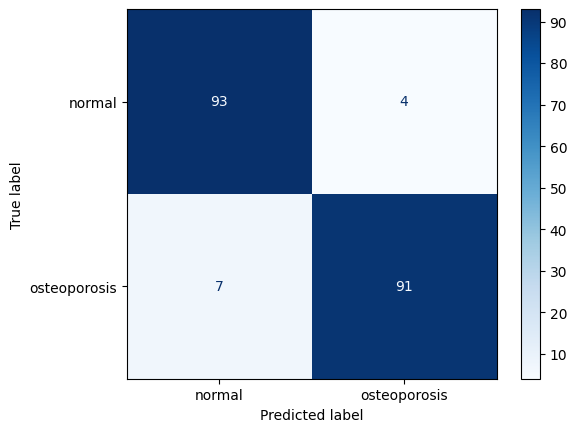

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Label mapping
class_labels = list(test_gen.class_indices.keys())

# Report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")


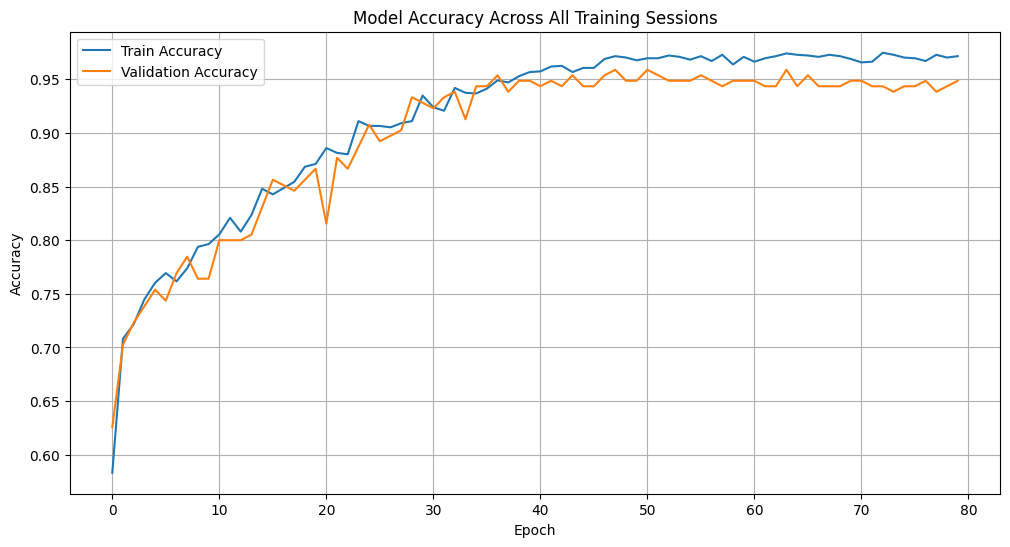

In [ ]:
import matplotlib.pyplot as plt

# List of all history objects
all_histories = [history, history1, history2, history3, history4, history5, history6]

# Combine all 'accuracy' and 'val_accuracy' values
train_acc = []
val_acc = []

for h in all_histories:
    train_acc += h.history['accuracy']
    val_acc += h.history['val_accuracy']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Across All Training Sessions')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


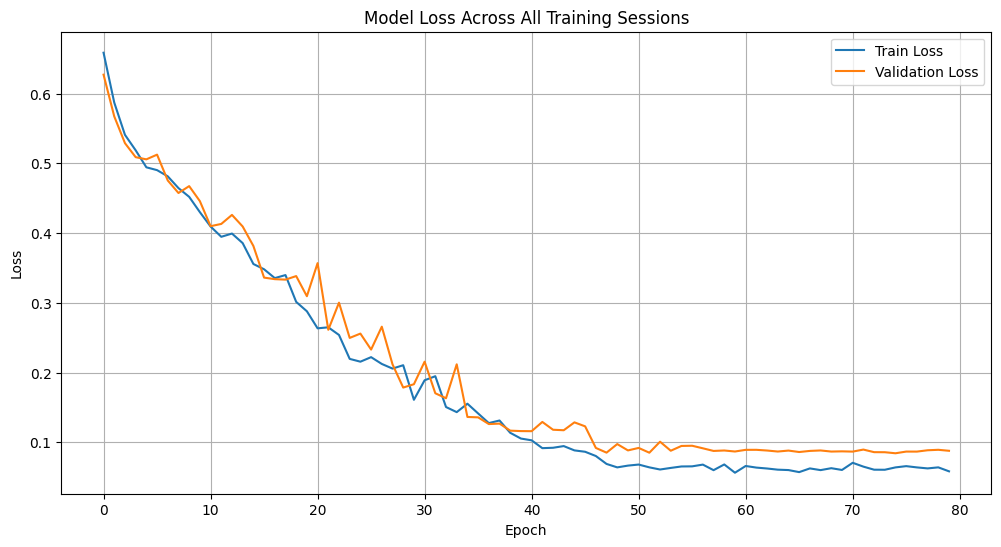

In [ ]:
import matplotlib.pyplot as plt

# List of all history objects
all_histories = [history, history1, history2, history3, history4, history5, history6]

# Combine all 'loss' and 'val_loss' values
train_loss = []
val_loss = []

for h in all_histories:
    train_loss += h.history['loss']
    val_loss += h.history['val_loss']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss Across All Training Sessions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))


              precision    recall  f1-score   support

      normal       0.50      1.00      0.66        97
osteoporosis       0.00      0.00      0.00        98

    accuracy                           0.50       195
   macro avg       0.25      0.50      0.33       195
weighted avg       0.25      0.50      0.33       195



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_18']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


AttributeError: 'numpy.ndarray' object has no attribute 'get_cmap'

In [ ]:
import numpy as np
unique, counts = np.unique(y_true, return_counts=True)
dict(zip(class_labels, counts))


{'normal': np.int64(97), 'osteoporosis': np.int64(98)}

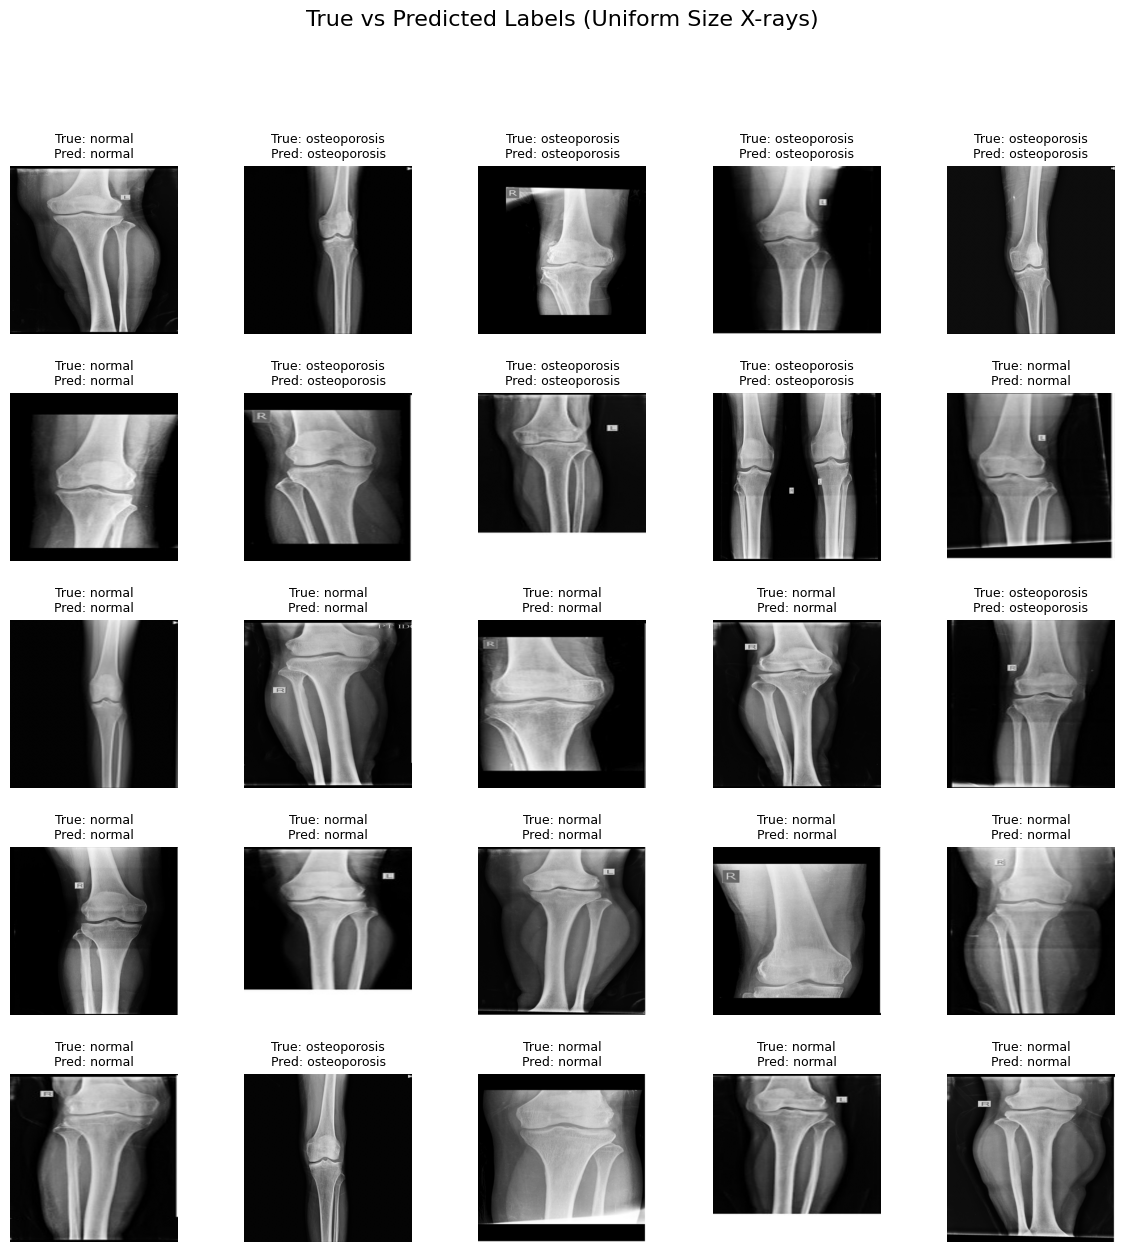

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

# Randomly sample 25 indices
indices = random.sample(range(len(file_paths)), 25)

# Define the target size for consistency
target_size = (300, 300)  # You can adjust this as needed

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img = Image.open(file_paths[idx]).convert('L')  # Convert to grayscale
    img = img.resize(target_size)  # Resize to uniform dimensions
    img = np.array(img)

    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred[idx]]

    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
    plt.axis('off')

plt.tight_layout(pad=2.0)
plt.suptitle("True vs Predicted Labels (Uniform Size X-rays)", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
import matplotlib.cm as mpl_cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # binary: 0 or 1
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + K.epsilon())
    return heatmap.numpy()

# --------- Grad-CAM Display Function ---------
def display_gradcam(image_path, model, last_conv_layer_name='conv2', label=''):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    heatmap = np.uint8(255 * heatmap)
    jet = mpl_cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM - {label}')
    plt.axis('off')
    plt.show()





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<ipython-input-60-b06d85a313b9>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl_cm.get_cmap("jet")


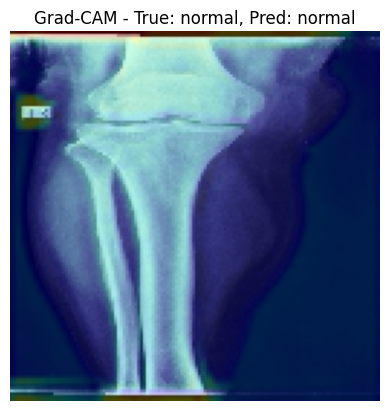

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


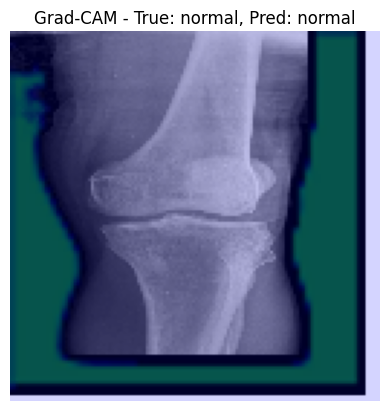

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


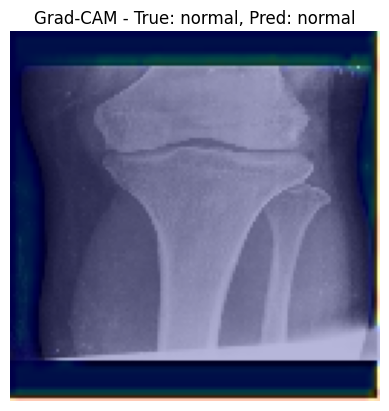

In [ ]:
import cv2
import numpy as np
import matplotlib.cm as mpl_cm

for idx in range(3):
    image_path = file_paths[idx]
    true_label = class_labels[y_true[idx]]

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize
    input_tensor = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(input_tensor)[0][0]
    pred_class = int(prediction > 0.5)
    pred_label = class_labels[pred_class]

    label = f"True: {true_label}, Pred: {pred_label}"

    # Display Grad-CAM
    display_gradcam(image_path, model, last_conv_layer_name='conv2d_5', label=label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


<ipython-input-60-b06d85a313b9>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl_cm.get_cmap("jet")


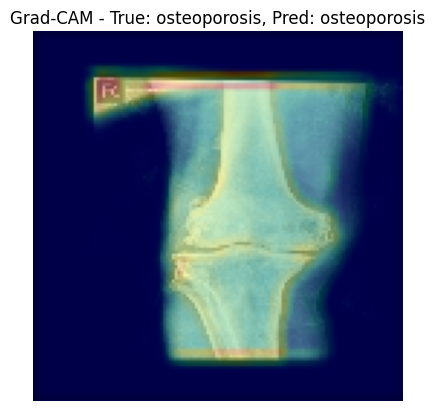

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


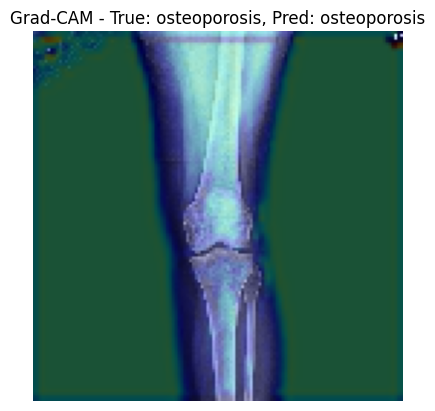

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


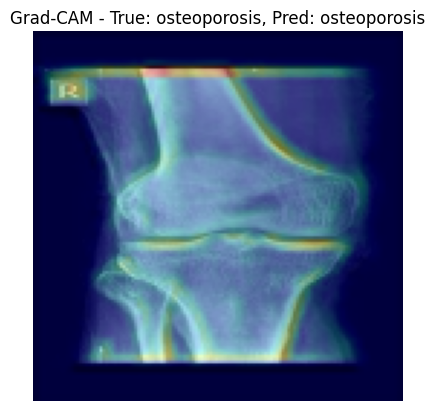

In [ ]:
import cv2
import numpy as np
import matplotlib.cm as mpl_cm
import random

# Get indices where true label is 'osteoporosis'
osteoporosis_indices = [i for i in range(len(file_paths)) if class_labels[y_true[i]] == "osteoporosis"]

# Randomly sample 3 osteoporosis indices
selected_indices = random.sample(osteoporosis_indices, 3)

for idx in selected_indices:
    image_path = file_paths[idx]
    true_label = class_labels[y_true[idx]]

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize
    input_tensor = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(input_tensor)[0][0]
    pred_class = int(prediction > 0.5)
    pred_label = class_labels[pred_class]

    label = f"True: {true_label}, Pred: {pred_label}"

    # Display Grad-CAM
    display_gradcam(image_path, model, last_conv_layer_name='conv2d_5', label=label)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')